## Local topology change under successful adversarial attacks (protocol notebook)

This notebook implements the protocol:

- For each **correctly classified** clean sample \(x\), generate a corresponding **successful** adversarial example \(x_{adv}\) (classifier flips).
- Compute embeddings \(z=\phi(x)\), \(z_{adv}=\phi(x_{adv})\) in the same representation space used by the detector.
- Quantify:
  1) **Neighborhood stability**: kNN overlap (Jaccard) and relative shift \(\Delta_{rel}\)
  2) **PH change**: local point clouds \(P(z)\), \(P(z_{adv})\) → persistence diagrams
  3) **Feature change**: topo summary vector deltas and detector score deltas
  4) **Clean-null baseline**: repeat with a matched clean perturbation \(x'\) that preserves prediction

If adversarial-vs-clean differences do **not** exceed the clean-null baseline and neighborhoods are stable (high J, small \(\Delta_{rel}\)), then local topology is effectively unchanged and topology features are unlikely to provide a meaningful detection signal.


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# repo-root discovery (no __file__ in notebooks)
def find_repo_root(start: Path) -> Path:
    start = Path(start).resolve()
    for p in [start, *start.parents]:
        if (p / "src").is_dir():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score

from src.data import generate_two_moons, create_data_loaders
from src.models import TwoMoonsMLP, train_model, extract_features_batch
from src.utils import GraphConfig, DetectorConfig, AttackConfig, ModelConfig
from src.adv_attacks import generate_adversarial_examples
from src.detectors import train_graph_detector
from src.topology_features import TopologyConfig, local_persistence_features

DEVICE = "cpu"
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True
print("repo root:", REPO_ROOT)


repo root: /Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs


In [2]:
# --- Configuration knobs for the protocol ---

# Neighborhood sizes to test
K_LIST = [10, 30, 60]

# Attack strengths to try (we will keep only *successful* adversarial examples)
EPS_LIST = [0.05, 0.10, 0.20, 0.30]

# How many clean points to attempt pairing for (kept small; PH is expensive)
N_PAIRS_TARGET = 40

# Clean-null perturbation noise (small; must preserve prediction)
CLEAN_NOISE_SIGMA = 0.02
CLEAN_NOISE_TRIES = 50

# PH settings
MAXDIM = 1
MIN_PERSISTENCE = 1e-6
TOPO_PREPROCESS = "none"  # 'none' or 'pca'
PCA_DIM = 10

print("K_LIST", K_LIST)
print("EPS_LIST", EPS_LIST)


K_LIST [10, 30, 60]
EPS_LIST [0.05, 0.1, 0.2, 0.3]


Epoch [10/200] Train Loss: 0.3284, Train Acc: 89.56%, Val Loss: 0.2843, Val Acc: 88.00%
Epoch [20/200] Train Loss: 0.1129, Train Acc: 97.22%, Val Loss: 0.1013, Val Acc: 98.67%
Epoch [30/200] Train Loss: 0.0390, Train Acc: 99.22%, Val Loss: 0.0333, Val Acc: 99.67%


Epoch [40/200] Train Loss: 0.0223, Train Acc: 99.44%, Val Loss: 0.0234, Val Acc: 99.33%
Epoch [50/200] Train Loss: 0.0135, Train Acc: 99.89%, Val Loss: 0.0157, Val Acc: 99.67%
Early stopping at epoch 55
final train acc: 98.33333333333333 final val acc: 97.66666666666667
Z_train std per-dim: [0.9302897  0.92742866 0.8977818 ]
test accuracy: 0.9766666666666667
seed pool size: 293


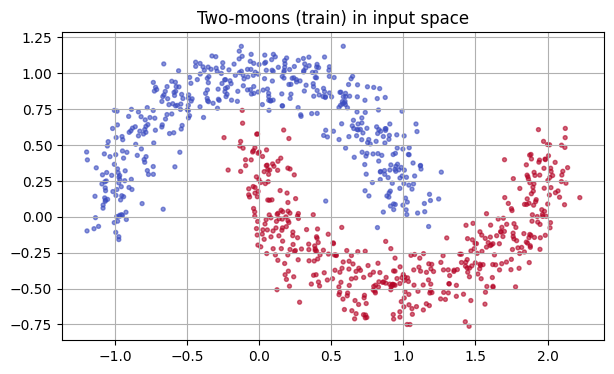

In [3]:
# --- 1) Train a small model and define the embedding space z=phi(x) ---

X_train, y_train, X_val, y_val, X_test, y_test = generate_two_moons(
    n_samples=1500,
    noise=0.12,
    random_state=SEED,
)

train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128
)

# Use tanh so embeddings don't collapse to ~0.
model = TwoMoonsMLP(input_dim=2, hidden_dims=[64, 32, 3], output_dim=2, activation="tanh")
hist = train_model(
    model,
    train_loader,
    val_loader,
    config=ModelConfig(epochs=200, learning_rate=5e-3, weight_decay=1e-4, batch_size=128),
    device=DEVICE,
)
model.eval()

print("final train acc:", hist["train_acc"][-1], "final val acc:", hist["val_acc"][-1])

# Embeddings for reference set
Z_train = extract_features_batch(model, X_train, layer="penultimate", device=DEVICE)
print("Z_train std per-dim:", np.std(Z_train, axis=0))

# Predictions on test for selecting correctly-classified clean seeds
with torch.no_grad():
    logits_test = model(torch.as_tensor(X_test, dtype=torch.float32))
    yhat_test = torch.argmax(logits_test, dim=1).cpu().numpy()

correct_mask = (yhat_test == y_test)
print("test accuracy:", float(np.mean(correct_mask)))

# We'll only attempt protocol pairs from correctly-classified samples.
X_seed = X_test[correct_mask]
y_seed = y_test[correct_mask]
print("seed pool size:", len(X_seed))

fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=8, cmap="coolwarm", alpha=0.6)
ax.set_title("Two-moons (train) in input space")
plt.show()


In [4]:
# --- Helpers: successful adversarial pairing + clean-null perturbations ---

@torch.no_grad()
def predict_label(model, X: np.ndarray) -> np.ndarray:
    t = torch.as_tensor(X, dtype=torch.float32)
    logits = model(t)
    return torch.argmax(logits, dim=1).cpu().numpy()


def find_successful_adversarials(
    *,
    model,
    X: np.ndarray,
    y_true: np.ndarray,
    eps_list: list[float],
    num_steps: int = 40,
    step_size: float = 0.02,
    batch_size: int = 64,
):
    """Return X_adv and a boolean success mask. Tries eps in increasing order."""
    y0 = predict_label(model, X)
    X_adv_best = X.copy()
    success = np.zeros((len(X),), dtype=bool)

    for eps in eps_list:
        cfg = AttackConfig(
            attack_type="pgd",
            epsilon=float(eps),
            num_steps=int(num_steps),
            step_size=float(step_size),
            random_start=True,
        )
        X_adv = generate_adversarial_examples(model, X=np.asarray(X), y=np.asarray(y_true), config=cfg, device=DEVICE, batch_size=int(batch_size))
        y_adv = predict_label(model, X_adv)
        newly = (~success) & (y_adv != y0)
        X_adv_best[newly] = X_adv[newly]
        success[newly] = True

        if np.all(success):
            break

    return X_adv_best, success


def matched_clean_perturbation(
    *,
    model,
    x: np.ndarray,
    yhat: int,
    sigma: float,
    tries: int,
):
    """Try small Gaussian perturbations that preserve prediction; fallback to x itself."""
    x = np.asarray(x, dtype=float)
    for _ in range(int(tries)):
        xp = x + np.random.normal(scale=float(sigma), size=x.shape)
        if int(predict_label(model, xp.reshape(1, -1))[0]) == int(yhat):
            return xp
    return x.copy()


In [5]:
# --- 2) Build successful (clean, adv) pairs and matched (clean, clean') baseline pairs ---

# Subsample seed pool for speed
idx = np.random.choice(len(X_seed), size=min(int(N_PAIRS_TARGET), len(X_seed)), replace=False)
X0 = np.asarray(X_seed)[idx]
y0 = np.asarray(y_seed)[idx]

# Successful adversarial examples (try eps in increasing order)
X_adv, success = find_successful_adversarials(
    model=model,
    X=X0,
    y_true=y0,
    eps_list=EPS_LIST,
    num_steps=50,
    step_size=0.02,
    batch_size=64,
)

# Keep only successful flips
X0 = X0[success]
y0 = y0[success]
X_adv = X_adv[success]

# Predictions for baseline matching
yhat0 = predict_label(model, X0)

# Matched clean perturbations x' that preserve prediction
X_null = np.stack([
    matched_clean_perturbation(model=model, x=x, yhat=int(yh), sigma=CLEAN_NOISE_SIGMA, tries=CLEAN_NOISE_TRIES)
    for x, yh in zip(X0, yhat0)
], axis=0)

print("paired points:", len(X0))

# Embeddings
Z0 = extract_features_batch(model, X0, layer="penultimate", device=DEVICE)
Z_adv = extract_features_batch(model, X_adv, layer="penultimate", device=DEVICE)
Z_null = extract_features_batch(model, X_null, layer="penultimate", device=DEVICE)

print("embedding shift stats ||z_adv-z||:", float(np.median(np.linalg.norm(Z_adv - Z0, axis=1))))
print("embedding shift stats ||z_null-z||:", float(np.median(np.linalg.norm(Z_null - Z0, axis=1))))


paired points: 15
embedding shift stats ||z_adv-z||: 1.9858930110931396
embedding shift stats ||z_null-z||: 0.03153729438781738


k=10: J_adv median=0.000, J_null median=0.429
     Δ_rel adv median=71.166, null median=0.951
k=30: J_adv median=0.000, J_null median=0.667
     Δ_rel adv median=37.796, null median=0.566
k=60: J_adv median=0.000, J_null median=0.818
     Δ_rel adv median=28.278, null median=0.384


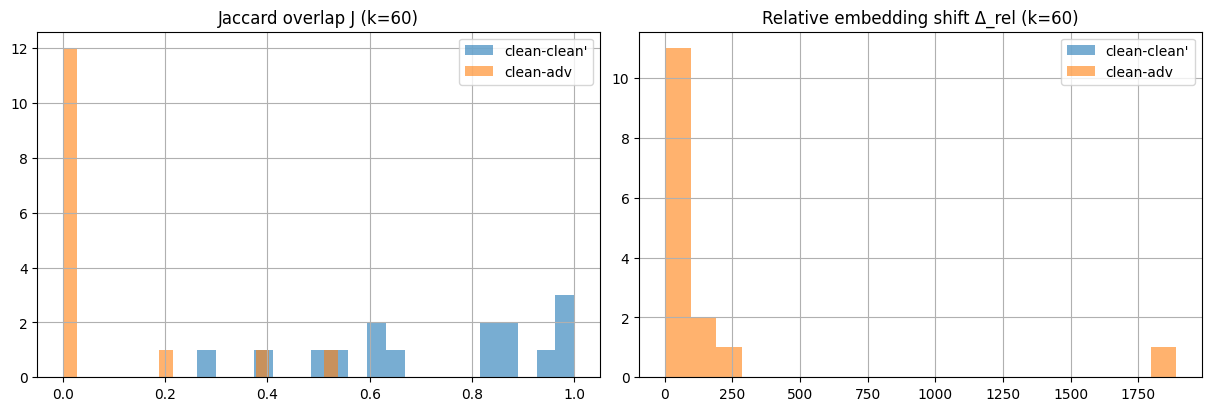

In [6]:
# --- 3) Neighborhood stability metrics (Jaccard overlap + Δ_rel) ---

# kNN index over training embeddings
nbrs = NearestNeighbors(n_neighbors=max(K_LIST), metric="euclidean").fit(Z_train)

# Precompute neighbor indices and distances for each k
# kneighbors gives sorted-by-distance neighbors

def knn_indices_and_dists(Zq: np.ndarray, k: int):
    d, idx = nbrs.kneighbors(Zq, n_neighbors=int(k), return_distance=True)
    return idx, d

results_geo = {}
for k in K_LIST:
    idx0, d0 = knn_indices_and_dists(Z0, k)
    idxA, dA = knn_indices_and_dists(Z_adv, k)
    idxN, dN = knn_indices_and_dists(Z_null, k)

    # Jaccard overlaps
    J_adv = []
    J_null = []
    for i in range(len(Z0)):
        s0 = set(idx0[i].tolist())
        sa = set(idxA[i].tolist())
        sn = set(idxN[i].tolist())
        J_adv.append(len(s0 & sa) / len(s0 | sa))
        J_null.append(len(s0 & sn) / len(s0 | sn))

    J_adv = np.asarray(J_adv, dtype=float)
    J_null = np.asarray(J_null, dtype=float)

    # Δ_rel = ||z_adv-z|| / median_{u in N_k(z)} ||z-u||
    delta_adv = np.linalg.norm(Z_adv - Z0, axis=1)
    delta_null = np.linalg.norm(Z_null - Z0, axis=1)
    r_k = np.median(d0, axis=1)  # distances to neighbors around z
    r_k = np.maximum(r_k, 1e-12)
    delta_rel_adv = delta_adv / r_k
    delta_rel_null = delta_null / r_k

    results_geo[k] = {
        'J_adv': J_adv,
        'J_null': J_null,
        'delta_rel_adv': delta_rel_adv,
        'delta_rel_null': delta_rel_null,
    }

    print(f"k={k}: J_adv median={np.median(J_adv):.3f}, J_null median={np.median(J_null):.3f}")
    print(f"     Δ_rel adv median={np.median(delta_rel_adv):.3f}, null median={np.median(delta_rel_null):.3f}")

# Plot distributions for the largest k (most stable)
k = max(K_LIST)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].hist(results_geo[k]['J_null'], bins=20, alpha=0.6, label="clean-clean'")
axes[0].hist(results_geo[k]['J_adv'], bins=20, alpha=0.6, label="clean-adv")
axes[0].set_title(f"Jaccard overlap J (k={k})")
axes[0].legend()

axes[1].hist(results_geo[k]['delta_rel_null'], bins=20, alpha=0.6, label="clean-clean'")
axes[1].hist(results_geo[k]['delta_rel_adv'], bins=20, alpha=0.6, label="clean-adv")
axes[1].set_title(f"Relative embedding shift Δ_rel (k={k})")
axes[1].legend()
plt.show()


k=10: median ||v_adv-v||=1.252 vs median ||v_null-v||=0.3893
k=30: median ||v_adv-v||=2.681 vs median ||v_null-v||=1.024
k=60: median ||v_adv-v||=3.692 vs median ||v_null-v||=1.023


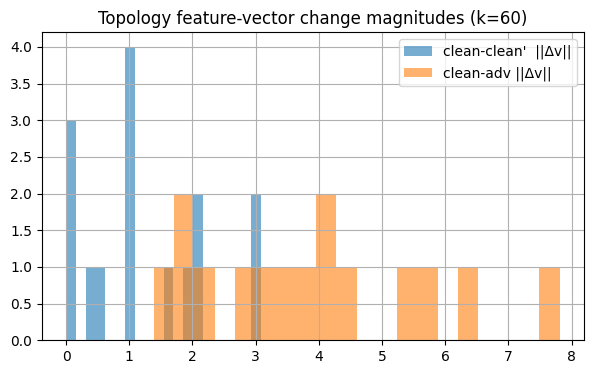


Feature-change AUROC: can |Δ feature| distinguish adv-changes from clean-null? (k=60)
topo_h0_l2_persistence       auc=0.960 median|Δ| null=0.01394 adv=0.377
topo_h0_total_persistence    auc=0.947 median|Δ| null=0.0946 adv=2.083
topo_h1_total_persistence    auc=0.929 median|Δ| null=0.002139 adv=0.1115
topo_h0_max_persistence      auc=0.913 median|Δ| null=0.001069 adv=0.1475
topo_h1_l2_persistence       auc=0.893 median|Δ| null=0.001197 adv=0.0544
topo_h1_max_persistence      auc=0.847 median|Δ| null=0.0001748 adv=0.04409
topo_h1_entropy              auc=0.800 median|Δ| null=0.06951 adv=0.3875
topo_h0_entropy              auc=0.733 median|Δ| null=0.01633 adv=0.07194
topo_h1_count                auc=0.724 median|Δ| null=1 adv=2
topo_h0_count                auc=0.500 median|Δ| null=0 adv=0

Heuristic:
- 9 topo feature-change metrics reach AUROC >= 0.65 vs clean-null (topology changes are detectable).


In [7]:
# --- 4) Topology: compute PH features/diagrams on P(z) and P(z_adv), compare to clean-null ---

# Build PH config
ph_cfg = TopologyConfig(
    neighborhood_k=max(K_LIST),
    maxdim=int(MAXDIM),
    metric="euclidean",
    thresh=None,
    min_persistence=float(MIN_PERSISTENCE),
    preprocess=str(TOPO_PREPROCESS),
    pca_dim=int(PCA_DIM),
)

# Helper: build local cloud = [query] + neighbors (in embedding space)

def local_cloud(Z_query: np.ndarray, idx_neighbors: np.ndarray) -> np.ndarray:
    # idx_neighbors: (n,k)
    clouds = []
    for i in range(len(Z_query)):
        neigh = Z_train[idx_neighbors[i]]
        cloud = np.vstack([Z_query[i].reshape(1, -1), neigh])
        clouds.append(cloud)
    return clouds


def feature_vec(feats: dict, keys: list[str]) -> np.ndarray:
    return np.array([float(feats.get(k, 0.0)) for k in keys], dtype=float)

# We will compute (for each k):
# - per-sample |v_adv - v_clean|_2 and |v_null - v_clean|_2
# - per-feature deltas

topo_keys = [
    'topo_h0_count','topo_h0_total_persistence','topo_h0_max_persistence','topo_h0_l2_persistence','topo_h0_entropy',
    'topo_h1_count','topo_h1_total_persistence','topo_h1_max_persistence','topo_h1_l2_persistence','topo_h1_entropy',
]

def safe_auc(a: np.ndarray, b: np.ndarray) -> float:
    y = np.concatenate([np.zeros(len(a)), np.ones(len(b))])
    x = np.concatenate([a, b])
    if len(np.unique(y)) < 2:
        return float('nan')
    return float(roc_auc_score(y, x))

results_topo = {}
for k in K_LIST:
    idx0, _ = knn_indices_and_dists(Z0, k)
    idxA, _ = knn_indices_and_dists(Z_adv, k)
    idxN, _ = knn_indices_and_dists(Z_null, k)

    clouds0 = local_cloud(Z0, idx0)
    cloudsA = local_cloud(Z_adv, idxA)
    cloudsN = local_cloud(Z_null, idxN)

    V0 = []
    VA = []
    VN = []

    for c0, cA, cN in zip(clouds0, cloudsA, cloudsN):
        f0 = local_persistence_features(c0, ph_cfg, return_diagrams=False)
        fA = local_persistence_features(cA, ph_cfg, return_diagrams=False)
        fN = local_persistence_features(cN, ph_cfg, return_diagrams=False)
        V0.append(feature_vec(f0, topo_keys))
        VA.append(feature_vec(fA, topo_keys))
        VN.append(feature_vec(fN, topo_keys))

    V0 = np.stack(V0, axis=0)
    VA = np.stack(VA, axis=0)
    VN = np.stack(VN, axis=0)

    d_adv = np.linalg.norm(VA - V0, axis=1)
    d_null = np.linalg.norm(VN - V0, axis=1)

    results_topo[k] = {'V0': V0, 'VA': VA, 'VN': VN, 'd_adv': d_adv, 'd_null': d_null}

    print(f"k={k}: median ||v_adv-v||={np.median(d_adv):.4g} vs median ||v_null-v||={np.median(d_null):.4g}")

    # Feature-wise AUROC: clean-null vs clean-adv deltas
    # Here we treat the *change magnitude* as the quantity.
    for j, key in enumerate(topo_keys[:5]):
        pass

# Plot vector-change distributions
k = max(K_LIST)
fig, ax = plt.subplots()
ax.hist(results_topo[k]['d_null'], bins=20, alpha=0.6, label="clean-clean'  ||Δv||")
ax.hist(results_topo[k]['d_adv'], bins=20, alpha=0.6, label="clean-adv ||Δv||")
ax.set_title(f"Topology feature-vector change magnitudes (k={k})")
ax.legend()
plt.show()

# Feature-wise change AUROC for one k
k = max(K_LIST)
V0 = results_topo[k]['V0']; VA = results_topo[k]['VA']; VN = results_topo[k]['VN']
rows = []
for j, key in enumerate(topo_keys):
    da = np.abs(VA[:, j] - V0[:, j])
    dn = np.abs(VN[:, j] - V0[:, j])
    rows.append((key, safe_auc(dn, da), float(np.median(dn)), float(np.median(da))))
rows.sort(key=lambda t: abs(t[1] - 0.5), reverse=True)
print(f"\nFeature-change AUROC: can |Δ feature| distinguish adv-changes from clean-null? (k={k})")
for key, auc, m_dn, m_da in rows:
    print(f"{key:28s} auc={auc:.3f} median|Δ| null={m_dn:.4g} adv={m_da:.4g}")

# Optional quick conclusion heuristic
better = [r for r in rows if np.isfinite(r[1]) and r[1] >= 0.65]
print("\nHeuristic:")
if len(better) == 0:
    print("- No topo feature-change metric reaches AUROC >= 0.65 vs clean-null (likely too similar).")
else:
    print(f"- {len(better)} topo feature-change metrics reach AUROC >= 0.65 vs clean-null (topology changes are detectable).")


score medians:
  clean: 31.658848632028096
  adv : 31.909656583266663
  null: 31.666273641799794


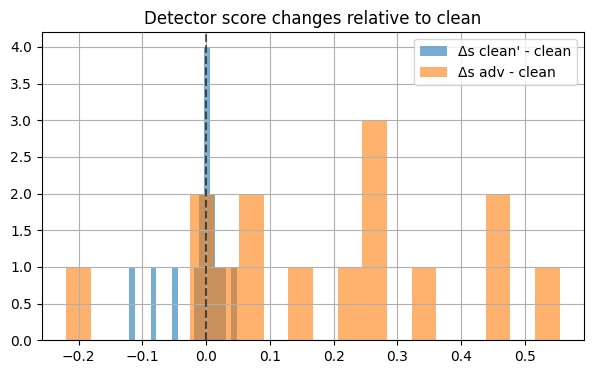

AUROC for Δs (adv vs clean-null): 0.8533333333333334


In [8]:
# --- 5) Pipeline-level scoring: does the detector score shift beyond clean-null? ---

# Compute topology feature dicts for detector training/scoring using existing pipeline keys.
# We'll train on a separate clean calibration subset of the training set.

N_CAL = 200
X_cal = X_train[:N_CAL]

# GraphConfig for feature-space topology scoring
cfg_graph = GraphConfig(
    use_topology=True,
    use_baseline_scores=False,
    space="feature",
    feature_layer="penultimate",
    topo_k=max(K_LIST),
    topo_maxdim=int(MAXDIM),
    topo_preprocess=str(TOPO_PREPROCESS),
    topo_pca_dim=int(PCA_DIM),
    topo_min_persistence=float(MIN_PERSISTENCE),
)

# Compute scores dicts (topo_* arrays) for calibration and for our paired points.
from src.graph_scoring import compute_graph_scores

f_train_dummy = np.zeros((len(X_train),), dtype=float)

scores_cal = compute_graph_scores(
    X_points=np.asarray(X_cal),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=cfg_graph,
    device=DEVICE,
)

scores_0 = compute_graph_scores(
    X_points=np.asarray(X0),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=cfg_graph,
    device=DEVICE,
)

scores_adv = compute_graph_scores(
    X_points=np.asarray(X_adv),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=cfg_graph,
    device=DEVICE,
)

scores_null = compute_graph_scores(
    X_points=np.asarray(X_null),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=cfg_graph,
    device=DEVICE,
)

# Fit detector on clean calibration scores
labels_cal = np.zeros((len(X_cal),), dtype=int)
det_cfg = DetectorConfig(topo_cov_shrinkage=1e-3, topo_percentile=95.0)
det = train_graph_detector(scores_cal, labels_cal, det_cfg)

s0 = det.score(scores_0)
sa = det.score(scores_adv)
sn = det.score(scores_null)

print("score medians:")
print("  clean:", float(np.median(s0)))
print("  adv :", float(np.median(sa)))
print("  null:", float(np.median(sn)))

# Compare (sa - s0) vs (sn - s0)
dS_adv = sa - s0
dS_null = sn - s0

fig, ax = plt.subplots()
ax.hist(dS_null, bins=20, alpha=0.6, label="Δs clean' - clean")
ax.hist(dS_adv, bins=20, alpha=0.6, label="Δs adv - clean")
ax.axvline(0.0, color="k", linestyle="--", alpha=0.6)
ax.set_title("Detector score changes relative to clean")
ax.legend()
plt.show()

# AUROC: can Δs distinguish adv from clean-null?
auc_ds = float(roc_auc_score(np.concatenate([np.zeros_like(dS_null), np.ones_like(dS_adv)]), np.concatenate([dS_null, dS_adv])))
print("AUROC for Δs (adv vs clean-null):", auc_ds)
